In [3]:
!pip install tensorflow
!pip install keras

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50

data_dir = "/content/drive/MyDrive/Teeth_Dataset"
train_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Training")
val_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Validation")
test_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Testing")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


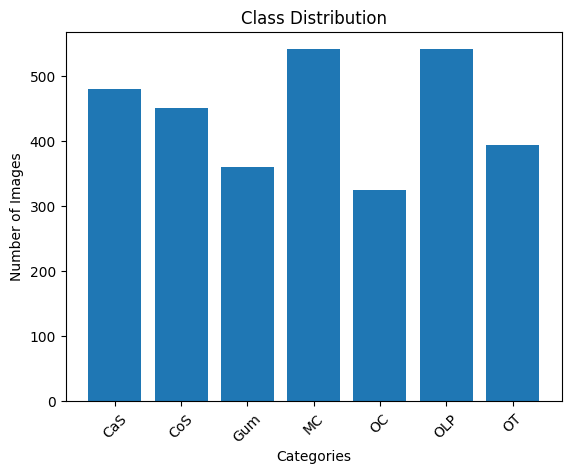

In [4]:
class_labels = list(train_generator.class_indices.keys())
class_counts = [len(os.listdir(os.path.join(train_dir, label))) for label in class_labels]
plt.bar(class_labels, class_counts)
plt.title("Class Distribution")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Call ResNet50
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False   # unfreeze last 10 layers

model = Sequential([
    base_model,  # Add Pretrained Base Model
    GlobalAveragePooling2D(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,859,463 (91.02 MB)

 Trainable params: 4,737,031 (18.07 MB)

 Non-trainable params: 19,122,432 (72.95 MB)

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'teeth_classification.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [9]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [10]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50 ,  callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1940s 20s/step - accuracy: 0.2110 - loss: 2.1116 - val_accuracy: 0.1167 - val_loss: 2.1155 - learning_rate: 1.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 587ms/step - accuracy: 0.3248 - loss: 1.8086 - val_accuracy: 0.1226 - val_loss: 2.0115 - learning_rate: 1.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 551ms/step - accuracy: 0.3539 - loss: 1.6853 - val_accuracy: 0.1829 - val_loss: 2.1100 - learning_rate: 1.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 0.3790 - loss: 1.6127 - val_accuracy: 0.1809 - val_loss: 2.4212 - learning_rate: 1.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 0.4078 - loss: 1.5707 - val_accuracy: 0.1955 - val_loss: 3.1577 - learning_rate: 1.0000e-04
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 543ms/step - accuracy: 0.4205 - loss: 1.5267 - val_accuracy: 0.1848 - val_loss: 2.5580 - learning_rate: 5.0000e-05
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 563ms/step - acc

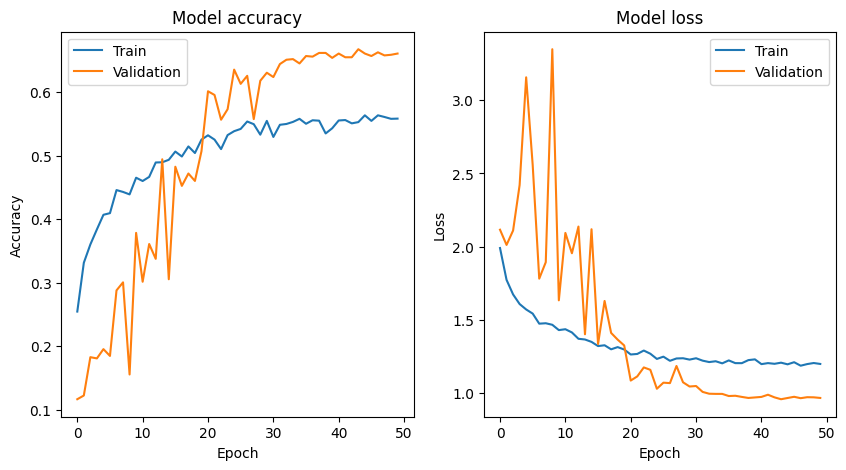

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 466s 15s/step - accuracy: 0.7042 - loss: 0.8866
Test Loss: 0.9601
Test Accuracy: 66.05%
